In [1]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import torch
import sounddevice as sd
import collections
import random
import matplotlib.pyplot as plt
import os, glob
import torch
from torch import nn
import torch.nn.functional as F
import tensorboardX
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from im_in_egg_unet1 import ImineggNet1
from pixel_shuffle import PixelShuffle1D
from trainer import Iminegg
from my_iterable_dataset import MyIterableDataset

C:\Users\alsa0217\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
def show_loudness(data):
    if isinstance(data, torch.Tensor): data = data.numpy()
    c = collections.Counter(data)
    m = dict(sorted(dict(c).items()))
    
    plt.figure(figsize=(16, 5))
    plt.semilogy(list(m.keys()), list(m.values()))
    plt.show()
    
#    lowest_count = (data < -10000).sum()
#    highest_count = (data > 10000).sum()
#    print('lowest_count:', lowest_count, lowest_count * 100 / len(data), '%' )
#    print('highest_count:', highest_count, lowest_count * 100 / len(data), '%')

In [3]:
device = torch.device("cuda")

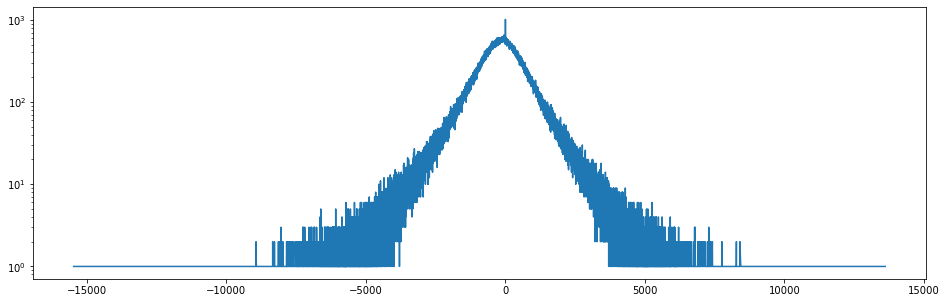

11025
(4796640,)


In [13]:
samplerate, data = wavfile.read('./data/train/voice/0015.wav')
_, noise = wavfile.read('./data/train/noise/00713.wav')
#sd.play(data[:50000], samplerate)
show_loudness(noise)
print(samplerate)
print(data.shape)

In [4]:
iminegg_net = ImineggNet1(2)

In [6]:
#iminegg_net.upsampling(iminegg_net.downsampling(torch.zeros(1, 1, train_sample_length).float()))


x, d_outs = iminegg_net.downsampling(torch.zeros(1, 1, train_sample_length).float())
x = iminegg_net.bottle_neck(x)
iminegg_net.upsampling(x, d_outs)

NameError: name 'train_sample_length' is not defined

In [ ]:
#sd.play(data[:samplerate*2] + noise[samplerate:samplerate*3] // 10 , samplerate)

In [5]:
iminegg = Iminegg(iminegg_net)

In [6]:
ds_train = MyIterableDataset(2000, "./data/train")
ds_validate = MyIterableDataset(100, "./data/val")

c:\ML\iminegg\my_iterable_dataset.py:19: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  self.voices.append(torch.from_numpy(data).float() / 32768)


In [43]:
trainer = pl.Trainer(max_epochs=30, gpus=1, logger=tb_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [24]:
tb_logger = pl_loggers.TensorBoardLogger('logs/')
trainer = pl.Trainer(resume_from_checkpoint="logs/default/version_0/checkpoints/epoch=28.ckpt",
                     max_epochs=32, gpus=1, logger=tb_logger)
train_set = DataLoader(ds_train, batch_size=20)
validate_set = DataLoader(ds_validate, batch_size=20)
trainer.fit(iminegg, train_set, validate_set)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\alsa0217\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name | Type        | Params
-------------------------------------
0 | net  | ImineggNet1 | 118 M 
C:\Users\alsa0217\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-processing data loading (e.g. batch size > 1), this can lead to unintended side effects since the samples will be duplicated.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

In [45]:
iminegg_net.load_state_dict(torch.load('m1.chkp'))
iminegg_net.eval()

ImineggNet1(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (conv1): Conv1d(1, 128, kernel_size=(65,), stride=(2,), padding=(32,))
  (conv2): Conv1d(128, 384, kernel_size=(33,), stride=(2,), padding=(16,))
  (conv3): Conv1d(384, 512, kernel_size=(17,), stride=(2,), padding=(8,))
  (conv4): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv5): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv6): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv7): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv8): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv_btlneck): Conv1d(512, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv8_up): Conv1d(512, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv7_up): Conv1d(1024, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv6_up): Conv1d(1024, 1024, kernel_size=(9,), stride=(

<ipython-input-8-56907183a47b>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  voices.append(torch.from_numpy(data).to(device).float())


In [254]:
dl = DataLoader(ds, batch_size=4)
next(iter(dl))

{'input': tensor([[-1703, -1614, -1330,  ...,   312,   633,   757],
         [ -254,  -104,   170,  ..., 10608, 11919, 12667],
         [-3496, -5741, -5815,  ..., -7884, -3682,  -280],
         [ 6611,  -565,   246,  ..., -1606, -1655, -1527]], device='cuda:0',
        dtype=torch.int16),
 'target': tensor([[    0.,     0.,     0.,  ...,     0.,     0.,     0.],
         [ -254.,  -104.,   170.,  ..., 10608., 11919., 12667.],
         [    0.,     0.,     0.,  ...,     0.,     0.,     0.],
         [ 6475.,  -632.,   296.,  ..., -1625., -1664., -1521.]],
        device='cuda:0')}

In [31]:
d = ds_train.generate_with_noise()
inp = d['input'].cpu()
target = d['target'].cpu()

In [32]:
sd.play(inp, samplerate)

In [33]:
iminegg_net.eval()
outp = iminegg_net.calc(torch.unsqueeze(torch.unsqueeze(inp, 0), 0)).reshape(-1)
outp.shape
sd.play(outp.cpu().detach().numpy(), samplerate)


In [33]:
export_outp = (outp.cpu() * 32768).short()
export_inp = (inp.cpu() * 32768).short()

wavfile.write('filtered_5.wav', samplerate, export_outp.detach().numpy())
wavfile.write('source_5.wav', samplerate, export_inp.detach().numpy())

In [13]:
sd.play(ds_train.generate_with_noise()['input'].cpu(), samplerate)

In [38]:
(inp-outp).abs().max()

tensor(0., grad_fn=<MaxBackward1>)

In [129]:
torch.save(iminegg_net.state_dict(), 'm1.chkp')

In [51]:
import gc
s = 0
for t in (filter(lambda x: isinstance(x, torch.cuda.FloatTensor), gc.get_objects() )):
    s += t.nelement()
s

945398809

In [68]:
d_noise = ds_train.generate_noise()
noise_inp = d_noise['input']

In [74]:
#sd.play(noise_inp.detach().numpy(), samplerate)

F.mse_loss(noise_inp, torch.zeros_like(noise_inp))

tensor(8.0493e-05)